Prep for Q1 and Q2

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def wrap_to_pi(angle):
    #Wrap an angle to the interval (-pi, pi].
    return (angle + np.pi) % (2*np.pi) - np.pi

def h_of_x(x):

    #Nonlinear radar measurement model:
    #  h1(x) = sqrt(x^2 + y^2)      (range)
    #  h2(x) = atan2(y, x)          (bearing)
    #State: x = [x, y, vx, vy]^T

    px, py = x[0], x[1]
    r = np.sqrt(px**2 + py**2)
    theta = np.arctan2(py, px)
    return np.array([r, theta])

def H_jacobian(x):
    #Jacobian of h(x): H = dh/dx with shape (2x4).

    px, py = x[0], x[1]
    r2 = px**2 + py**2
    r = np.sqrt(r2)

    # Numerical safety for very small range
    eps = 1e-9
    r = max(r, eps)
    r2 = max(r2, eps)

    # Partial derivatives for range
    dh1_dpx = px / r
    dh1_dpy = py / r

    # Partial derivatives for bearing
    dh2_dpx = -py / r2
    dh2_dpy =  px / r2

    H = np.array([
        [dh1_dpx, dh1_dpy, 0.0, 0.0],
        [dh2_dpx, dh2_dpy, 0.0, 0.0],
    ])
    return H


In [2]:
np.random.seed(7)

dt = 0.5
T = 30

sigma_w2 = 0.01     # process noise variance
sigma1_2 = 0.1      # range measurement noise variance
sigma2_2 = 0.01     # bearing measurement noise variance

# State: x_k = [x_k, y_k, vx_k, vy_k]^T
F = np.array([
    [1, 0, dt, 0 ],
    [0, 1, 0,  dt],
    [0, 0, 1, 0 ],
    [0, 0, 0, 1 ],
], dtype=float)

# Q = sigma_w^2 * [[(1/4)dt^4,   0, (1/2)dt^3,   0],
#                  [0, (1/4)dt^4,   0, (1/2)dt^3],
#                  [(1/2)dt^3,   0,     dt^2,   0],
#                  [0, (1/2)dt^3,   0,     dt^2]]
Q_base = np.array([
    [0.25*dt**4,      0.0, 0.5*dt**3,      0.0],
    [0.0,       0.25*dt**4,     0.0, 0.5*dt**3],
    [0.5*dt**3,      0.0,    dt**2,      0.0],
    [0.0,       0.5*dt**3,     0.0,    dt**2],
], dtype=float)
Q = sigma_w2 * Q_base

# Measurement noise covariance
R = np.array([
    [sigma1_2, 0.0],
    [0.0, sigma2_2],
], dtype=float)

# Initial state distribution: x0 ~ N(mu0, P0)
mu0 = np.array([-20.0, -20.0, 2.0, 2.0])
P0 = np.diag([10.0, 10.0, 0.01, 0.01])


In [3]:
x_true = np.zeros((T+1, 4))
z_meas = np.zeros((T, 2))

# Sample x0 from the given Gaussian prior
x_true[0] = np.random.multivariate_normal(mean=mu0, cov=P0)

# State propagation using the linear process model and process noise
for k in range(1, T+1):
    w_k = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
    x_true[k] = F @ x_true[k-1] + w_k

# Measurement generation using the nonlinear radar model and measurement noise
for k in range(1, T+1):
    v_k = np.random.multivariate_normal(mean=np.zeros(2), cov=R)
    z = h_of_x(x_true[k]) + v_k
    z[1] = wrap_to_pi(z[1])  # normalize bearing to (-pi, pi]
    z_meas[k-1] = z

x_true[:3], z_meas[:3]


(array([[-14.65408833, -21.47342334,   2.00328202,   2.04075163],
        [-13.64258579, -20.4530217 ,   2.04272817,   2.04085491],
        [-12.63394243, -19.42508802,   1.99184527,   2.07087983]]),
 array([[24.56151403, -2.08091371],
        [23.3267103 , -2.11122881],
        [22.07391902, -2.10682705]]))

In [4]:
x_hat = np.zeros((T+1, 4))
P_hat = np.zeros((T+1, 4, 4))

# Initialize the filter with the given prior mean and covariance
x_hat[0] = mu0.copy()
P_hat[0] = P0.copy()

I = np.eye(4)

for k in range(1, T+1):
    # 1) Prediction step
    x_pred = F @ x_hat[k-1]
    P_pred = F @ P_hat[k-1] @ F.T + Q

    # 2) Linearize measurement model around the predicted state
    H = H_jacobian(x_pred)

    # 3) Innovation (measurement residual)
    z_pred = h_of_x(x_pred)
    y = z_meas[k-1] - z_pred
    y[1] = wrap_to_pi(y[1])  # normalize the bearing innovation

    # 4) Compute innovation covariance and Kalman gain
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    # 5) Update step
    x_upd = x_pred + K @ y

    # Joseph stabilized covariance update (improves numerical stability)
    P_upd = (I - K @ H) @ P_pred @ (I - K @ H).T + K @ R @ K.T

    # Store results
    x_hat[k] = x_upd
    P_hat[k] = P_upd

x_hat[:3]


array([[-20.        , -20.        ,   2.        ,   2.        ],
       [-14.34607233, -20.42146992,   2.00261714,   1.99920064],
       [-13.20627091, -19.37817124,   2.00888876,   2.00526383]])

Question 1

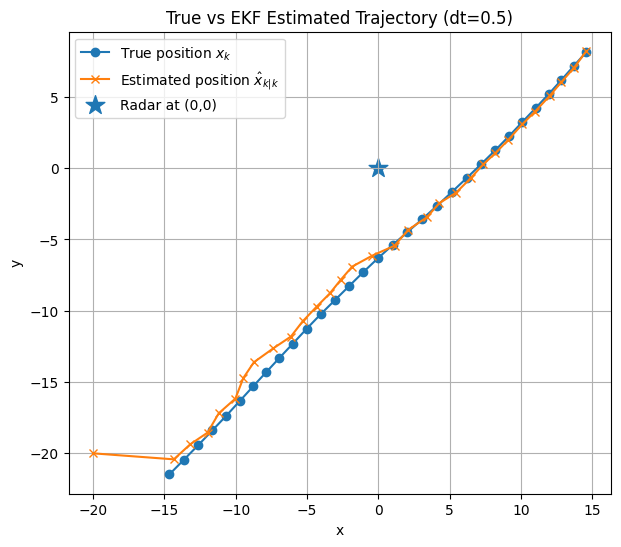

In [5]:
plt.figure(figsize=(7, 6))
plt.plot(x_true[:, 0], x_true[:, 1], marker='o', label='True position $x_k$')
plt.plot(x_hat[:, 0],  x_hat[:, 1],  marker='x', label='Estimated position $\\hat{x}_{k|k}$')

plt.scatter([0], [0], marker='*', s=200, label='Radar at (0,0)')
plt.axis('equal')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'True vs EKF Estimated Trajectory (dt={dt})')
plt.legend()
plt.show()


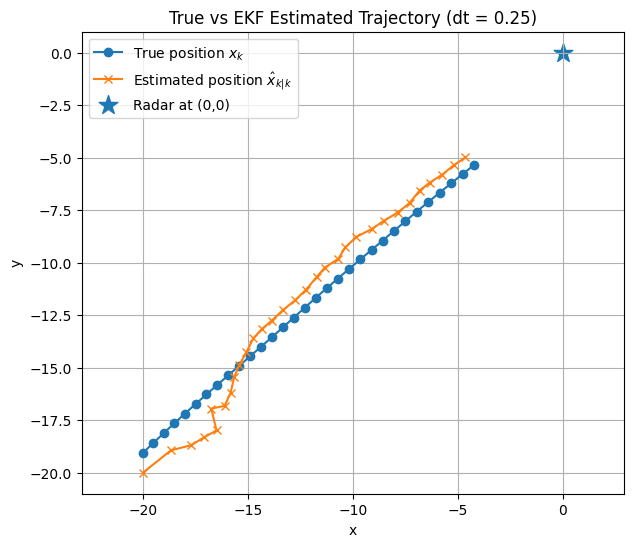

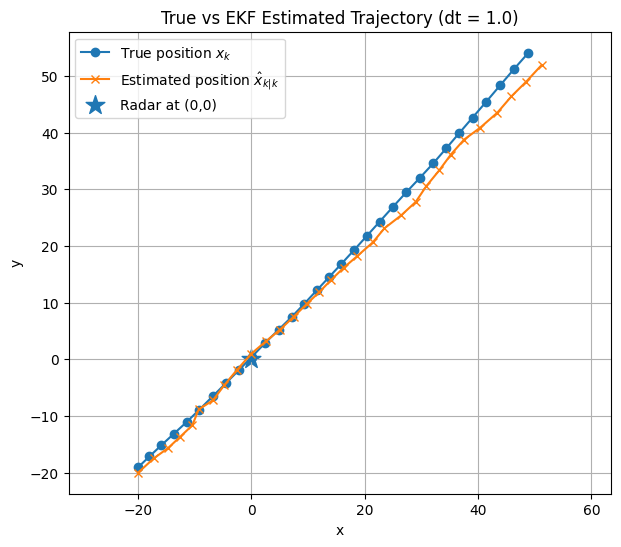

In [6]:
def run_sim_and_ekf(dt, T=30, seed=7,
                   sigma_w2=0.01, sigma1_2=0.1, sigma2_2=0.01,
                   mu0=np.array([-20.0, -20.0, 2.0, 2.0]),
                   P0=np.diag([10.0, 10.0, 0.01, 0.01])):

    rng = np.random.default_rng(seed)

    F = np.array([
        [1, 0, dt, 0 ],
        [0, 1, 0,  dt],
        [0, 0, 1, 0 ],
        [0, 0, 0, 1 ],
    ], dtype=float)

    Q_base = np.array([
        [0.25*dt**4,      0.0, 0.5*dt**3,      0.0],
        [0.0,       0.25*dt**4,     0.0, 0.5*dt**3],
        [0.5*dt**3,      0.0,    dt**2,      0.0],
        [0.0,       0.5*dt**3,     0.0,    dt**2],
    ], dtype=float)
    Q = sigma_w2 * Q_base

    R = np.array([
        [sigma1_2, 0.0],
        [0.0, sigma2_2],
    ], dtype=float)

    x_true = np.zeros((T+1, 4))
    z_meas = np.zeros((T, 2))

    x_true[0] = rng.multivariate_normal(mean=mu0, cov=P0)

    for k in range(1, T+1):
        w_k = rng.multivariate_normal(mean=np.zeros(4), cov=Q)
        x_true[k] = F @ x_true[k-1] + w_k

    for k in range(1, T+1):
        v_k = rng.multivariate_normal(mean=np.zeros(2), cov=R)
        z = h_of_x(x_true[k]) + v_k
        z[1] = wrap_to_pi(z[1])
        z_meas[k-1] = z

    # --- EKF to estimate x_hat_{k|k} ---
    x_hat = np.zeros((T+1, 4))
    P_hat = np.zeros((T+1, 4, 4))

    x_hat[0] = mu0.copy()
    P_hat[0] = P0.copy()

    I = np.eye(4)

    for k in range(1, T+1):
        # Predict
        x_pred = F @ x_hat[k-1]
        P_pred = F @ P_hat[k-1] @ F.T + Q

        # Jacobian at x_pred = x_hat_{k|k-1}
        H = H_jacobian(x_pred)

        # Innovation
        z_pred = h_of_x(x_pred)
        y = z_meas[k-1] - z_pred
        y[1] = wrap_to_pi(y[1])

        # Update
        S = H @ P_pred @ H.T + R
        K = P_pred @ H.T @ np.linalg.inv(S)
        x_hat[k] = x_pred + K @ y
        P_hat[k] = (I - K @ H) @ P_pred @ (I - K @ H).T + K @ R @ K.T

    return x_true, x_hat

# Run for the two requested sampling intervals
x_true_025, x_hat_025 = run_sim_and_ekf(dt=0.25, T=T, seed=7,
                                       sigma_w2=sigma_w2, sigma1_2=sigma1_2, sigma2_2=sigma2_2,
                                       mu0=mu0, P0=P0)

x_true_1, x_hat_1 = run_sim_and_ekf(dt=1.0, T=T, seed=7,
                                   sigma_w2=sigma_w2, sigma1_2=sigma1_2, sigma2_2=sigma2_2,
                                   mu0=mu0, P0=P0)

# Plot (true vs estimated) for dt = 0.25
plt.figure(figsize=(7, 6))
plt.plot(x_true_025[:,0], x_true_025[:,1], marker='o', label='True position $x_k$')
plt.plot(x_hat_025[:,0],  x_hat_025[:,1],  marker='x', label='Estimated position $\\hat{x}_{k|k}$')
plt.scatter([0],[0], marker='*', s=200, label='Radar at (0,0)')
plt.axis('equal'); plt.grid(True)
plt.xlabel('x'); plt.ylabel('y')
plt.title('True vs EKF Estimated Trajectory (dt = 0.25)')
plt.legend()
plt.show()

# Plot (true vs estimated) for dt = 1.0
plt.figure(figsize=(7, 6))
plt.plot(x_true_1[:,0], x_true_1[:,1], marker='o', label='True position $x_k$')
plt.plot(x_hat_1[:,0],  x_hat_1[:,1],  marker='x', label='Estimated position $\\hat{x}_{k|k}$')
plt.scatter([0],[0], marker='*', s=200, label='Radar at (0,0)')
plt.axis('equal'); plt.grid(True)
plt.xlabel('x'); plt.ylabel('y')
plt.title('True vs EKF Estimated Trajectory (dt = 1.0)')
plt.legend()
plt.show()


Question 2

In [7]:
#(sa=(0,0), sb=(5,0))

sa = np.array([0.0, 0.0])
sb = np.array([5.0, 0.0])

def h_two_sensors(x, sa, sb):
    px, py = x[0], x[1]

    # sensor a
    dxa, dya = px - sa[0], py - sa[1]
    ra = np.sqrt(dxa**2 + dya**2)
    thetaa = np.arctan2(dya, dxa)

    # sensor b
    dxb, dyb = px - sb[0], py - sb[1]
    rb = np.sqrt(dxb**2 + dyb**2)
    thetab = np.arctan2(dyb, dxb)

    return np.array([ra, rb, thetaa, thetab])

def H_two_sensors_jacobian(x, sa, sb):
    px, py = x[0], x[1]
    eps = 1e-9

    # sensor a terms
    dxa, dya = px - sa[0], py - sa[1]
    r2a = dxa**2 + dya**2
    ra = np.sqrt(max(r2a, eps))
    r2a = max(r2a, eps)

    dra_dx_a = dxa / ra
    dra_dy_a = dya / ra
    dth_dx_a = -dya / r2a
    dth_dy_a =  dxa / r2a

    # sensor b terms
    dxb, dyb = px - sb[0], py - sb[1]
    r2b = dxb**2 + dyb**2
    rb = np.sqrt(max(r2b, eps))
    r2b = max(r2b, eps)

    drb_dx_b = dxb / rb
    drb_dy_b = dyb / rb
    dth_dx_b = -dyb / r2b
    dth_dy_b =  dxb / r2b

    H = np.array([
        [dra_dx_a, dra_dy_a, 0.0, 0.0],  # ra
        [drb_dx_b, drb_dy_b, 0.0, 0.0],  # rb
        [dth_dx_a, dth_dy_a, 0.0, 0.0],  # theta_a
        [dth_dx_b, dth_dy_b, 0.0, 0.0],  # theta_b
    ])
    return H


In [8]:
F = np.array([
    [1, 0, dt, 0 ],
    [0, 1, 0,  dt],
    [0, 0, 1, 0 ],
    [0, 0, 0, 1 ],
], dtype=float)

Q_base = np.array([
    [0.25*dt**4,      0.0, 0.5*dt**3,      0.0],
    [0.0,       0.25*dt**4,     0.0, 0.5*dt**3],
    [0.5*dt**3,      0.0,    dt**2,      0.0],
    [0.0,       0.5*dt**3,     0.0,    dt**2],
], dtype=float)
Q = sigma_w2 * Q_base

R2 = np.diag([sigma1_2, sigma1_2, sigma2_2, sigma2_2])

x_true2 = np.zeros((T+1, 4))
z_meas2 = np.zeros((T, 4))

# Initial state
x_true2[0] = np.random.multivariate_normal(mean=mu0, cov=P0)

# Propagate states
for k in range(1, T+1):
    w_k = np.random.multivariate_normal(mean=np.zeros(4), cov=Q)
    x_true2[k] = F @ x_true2[k-1] + w_k

# Generate 4D measurements
for k in range(1, T+1):
    v_k = np.random.multivariate_normal(mean=np.zeros(4), cov=R2)
    z = h_two_sensors(x_true2[k], sa, sb) + v_k
    z[2] = wrap_to_pi(z[2])  # theta_a
    z[3] = wrap_to_pi(z[3])  # theta_b
    z_meas2[k-1] = z

z_meas2[:3]


array([[30.67206039, 33.8359094 , -2.28196919, -2.45287916],
       [30.09433802, 33.00611372, -2.2994885 , -2.39649054],
       [29.17064579, 31.30842779, -2.28511146, -2.30631617]])

In [9]:
x_hat2 = np.zeros((T+1, 4))
P_hat2 = np.zeros((T+1, 4, 4))

x_hat2[0] = mu0.copy()
P_hat2[0] = P0.copy()

I = np.eye(4)

for k in range(1, T+1):
    # Predict
    x_pred = F @ x_hat2[k-1]
    P_pred = F @ P_hat2[k-1] @ F.T + Q

    # Linearize measurement model at x_pred
    Hk = H_two_sensors_jacobian(x_pred, sa, sb)

    # Innovation
    z_pred = h_two_sensors(x_pred, sa, sb)
    y = z_meas2[k-1] - z_pred
    y[2] = wrap_to_pi(y[2])  # bearing innovation for sensor a
    y[3] = wrap_to_pi(y[3])  # bearing innovation for sensor b

    # Update
    S = Hk @ P_pred @ Hk.T + R2
    K = P_pred @ Hk.T @ np.linalg.inv(S)

    x_upd = x_pred + K @ y
    P_upd = (I - K @ Hk) @ P_pred @ (I - K @ Hk).T + K @ R2 @ K.T

    x_hat2[k] = x_upd
    P_hat2[k] = P_upd


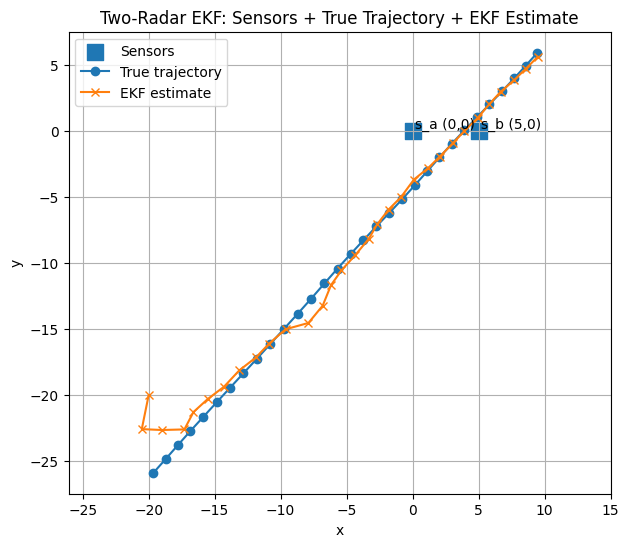

In [10]:
plt.figure(figsize=(7, 6))

# Sensors
plt.scatter([sa[0], sb[0]], [sa[1], sb[1]], s=120, marker='s', label='Sensors')
plt.text(sa[0]+0.2, sa[1]+0.2, 's_a (0,0)')
plt.text(sb[0]+0.2, sb[1]+0.2, 's_b (5,0)')

# Trajectories
plt.plot(x_true2[:,0], x_true2[:,1], marker='o', label='True trajectory')
plt.plot(x_hat2[:,0],  x_hat2[:,1],  marker='x', label='EKF estimate')

plt.axis('equal')
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Two-Radar EKF: Sensors + True Trajectory + EKF Estimate')
plt.legend()
plt.show()
